In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [17]:
# MODIFIED: Generate Synthetic Credit Risk Dataset with improvements
# Changes: (1) Balanced default rate ~40-60%, (2) More asymmetric costs,
# (3) Additional noise/interaction features

def generate_credit_risk_data(n_samples=10000):
    """
    Generate synthetic credit risk dataset with instance-dependent costs.

    MODIFIED: More balanced default rate (target ~40-60% instead of ~88%)

    Features:
    - credit_score: credit score (300-850)
    - income: annual income
    - debt_to_income: debt-to-income ratio
    - employment_length: years of employment
    - loan_amount: loan amount (determines instance-dependent cost)
    - interest_rate: interest rate
    - loan_term: loan term in months
    ADDED: noise_feature_1, noise_feature_2, interaction_term

    Target:
    - default: 1 if default, 0 otherwise
    """

    # Generate features
    credit_score = np.random.normal(680, 80, n_samples).clip(300, 850)
    income = np.random.lognormal(10.8, 0.6, n_samples).clip(20000, 500000)
    debt_to_income = np.random.beta(2, 5, n_samples) * 0.6
    employment_length = np.random.exponential(5, n_samples).clip(0, 40)
    loan_amount = np.random.lognormal(10.5, 0.8, n_samples).clip(5000, 500000)
    interest_rate = np.random.normal(0.12, 0.04, n_samples).clip(0.05, 0.30)
    loan_term = np.random.choice([12, 24, 36, 48, 60], n_samples)

    # ADDED: Additional features - noise and interaction terms
    noise_feature_1 = np.random.normal(0, 1, n_samples)  # Random noise
    noise_feature_2 = np.random.normal(0, 1, n_samples)  # Random noise
    # Interaction term: debt-to-income * loan_amount
    interaction_term = debt_to_income * (loan_amount / 100000)

    # MODIFIED: Adjusted default score formula for ~40-60% default rate
    # Reduced coefficients significantly to lower default probability
    default_score = (
        -0.005 * (credit_score - 680) +  # Reduced from -0.01
        -0.00001 * (income - 60000) +     # Reduced from -0.00002
        1.0 * debt_to_income +             # Reduced from 2.0
        -0.025 * employment_length +       # Reduced from -0.05
        0.000002 * loan_amount +           # Reduced from 0.000005
        7.5 * interest_rate +              # Reduced from 15.0
        0.005 * loan_term +                # Reduced from 0.01
        0.1 * interaction_term -           # Added interaction
        1.5                                 # Shift baseline down
    )

    # Convert to probability
    default_prob = 1 / (1 + np.exp(-default_score))
    default = (np.random.rand(n_samples) < default_prob).astype(int)

    # Create DataFrame with ADDED features
    df = pd.DataFrame({
        'credit_score': credit_score,
        'income': income,
        'debt_to_income': debt_to_income,
        'employment_length': employment_length,
        'loan_amount': loan_amount,
        'interest_rate': interest_rate,
        'loan_term': loan_term,
        'noise_feature_1': noise_feature_1,           # ADDED
        'noise_feature_2': noise_feature_2,           # ADDED
        'interaction_term': interaction_term,         # ADDED
        'default': default
    })

    return df

# Generate dataset
print("Generating synthetic credit risk dataset...")
df = generate_credit_risk_data(10000)
print(f"Dataset shape: {df.shape}")
print(f"\nDefault rate: {df['default'].mean():.2%}")  # Should be ~40-60%
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset statistics:")
print(df.describe())

Generating synthetic credit risk dataset...
Dataset shape: (10000, 11)

Default rate: 43.63%

First few rows:
   credit_score        income  debt_to_income  employment_length  \
0    633.320046  50416.151407        0.086489           5.304580   
1    774.139181  20000.000000        0.175070           5.047478   
2    850.000000  67923.815886        0.105612           6.070649   
3    559.281700  54271.292585        0.199829           2.385960   
4    660.922486  23113.938509        0.273913           3.028118   

    loan_amount  interest_rate  loan_term  noise_feature_1  noise_feature_2  \
0   7781.952791       0.176396         60         0.084460        -0.069179   
1   8494.419586       0.109779         48         1.827700        -0.240647   
2  80751.285344       0.122679         24        -0.059607        -1.033816   
3  23134.812119       0.161870         24         1.201858         0.116729   
4  25742.992650       0.120534         60        -0.012137        -1.483179   

   int

In [36]:
df = pd.read_csv("scaled_combined.csv")
df.drop(columns=['PLY_PRD',	'CST_OCP', 'UCP_RSN', 'OWS_DTL', 'REGISTERED_DATE', 'LOSS_DATE', 'CLAIM_TYPE_DESCRIPTION', 'INVEST_DATE', 'Closed Date', 'ACTION_STATUS_DESCRIPTION', 'PRODUCT_CODE', 'Rule Outcome Code', 'ENQUIRY_REALTIME_RESULT_CREATE_DATE_TIME'], inplace=True)
df

,TIR_PRM_AM,UCP_DY,SUM_INU,PRM_AM,PRM_WTH_IPT,RSK_PRM_INC_CRD_SCR,RSK_PRM_NO_CRD_SCR,CVR_IND,CVR_TYP_LMT,CVR_SEL,...,MAN_PRT_PRM,ACD_PRM,OBL_PRM,PRV_ISN_BLD,PRV_ISN_CNE,PPT_ELG,RSK_PRM_OVR_TAX_SCG,CTS_CLM_CNT,SAVED_VALUE_ESTIMATE,REASON
0,54.831143,30.0,53586.775047,66.274924,17.302418,6.322581,0.000000,0.0,18759.297082,1.0,...,0.000000,0.215706,0.389716,1.687749,92.092519,0.0,44.460789,0.0,2625.546494,Fraud Suspected - Claim Paid
1,19.390195,30.0,35217.558724,43.006644,14.675441,85.336935,8.848427,1.0,2653.103675,1.0,...,0.374891,0.097264,0.496572,6.667294,0.000000,0.0,34.769147,1.0,0.000000,Null
2,24.331853,30.0,493601.101832,7.739236,180.696323,49.402941,19.950876,1.0,6182.371068,0.0,...,3.428828,0.103686,0.044666,0.000000,0.000000,1.0,28.201005,0.0,195.521924,Fraud Suspected - Claim Paid
3,12.033154,30.0,0.000000,4.337741,0.000000,82.990501,21.642106,1.0,6189.004035,0.0,...,7.930365,0.000000,0.000000,0.000000,24.489830,1.0,14.361833,0.0,365.250286,Fraud Suspected - Invented
4,0.000000,30.0,22948.918776,74.087064,0.000000,48.436736,13.898766,0.0,18331.626729,0.0,...,1.037383,0.000000,0.839843,23.899667,75.108415,1.0,39.575851,1.0,0.000000,Null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,33.998915,60.0,110603.415118,0.000000,0.000000,89.729915,96.417837,1.0,16969.743740,0.0,...,0.000000,0.137823,0.292332,34.416731,15.583184,1.0,158.169020,1.0,0.000000,Null
14996,0.000000,30.0,230409.839048,44.966695,0.000000,29.726556,23.059648,0.0,31183.374723,1.0,...,5.727226,0.085118,0.294469,99.000000,13.390587,1.0,58.256809,0.0,1201.460943,Null
14997,29.929342,30.0,93301.075209,0.000000,0.000000,63.318140,18.719727,0.0,0.000000,1.0,...,3.876667,0.032674,0.575320,13.164187,76.410090,1.0,174.790000,0.0,4313.937919,Fraud Suspected - Exaggerated
14998,331.360003,30.0,121610.338766,9.133898,0.000000,89.046699,83.158059,0.0,10937.575134,1.0,...,14.858257,0.289431,0.094456,14.232055,99.000000,1.0,53.213779,0.0,3954.761990,Insurance Claim - Misrepresentation of Circums...


In [37]:
sum(df['SAVED_VALUE_ESTIMATE']==0)

5275

In [38]:
print(sum(df['REASON']=="Null"))
print(df['REASON'].nunique())

df['REASON'][df['REASON']!="Null"] = 1
df['REASON'][df['REASON']=="Null"] = 0

df

6154
24


,TIR_PRM_AM,UCP_DY,SUM_INU,PRM_AM,PRM_WTH_IPT,RSK_PRM_INC_CRD_SCR,RSK_PRM_NO_CRD_SCR,CVR_IND,CVR_TYP_LMT,CVR_SEL,...,MAN_PRT_PRM,ACD_PRM,OBL_PRM,PRV_ISN_BLD,PRV_ISN_CNE,PPT_ELG,RSK_PRM_OVR_TAX_SCG,CTS_CLM_CNT,SAVED_VALUE_ESTIMATE,REASON
0,54.831143,30.0,53586.775047,66.274924,17.302418,6.322581,0.000000,0.0,18759.297082,1.0,...,0.000000,0.215706,0.389716,1.687749,92.092519,0.0,44.460789,0.0,2625.546494,1
1,19.390195,30.0,35217.558724,43.006644,14.675441,85.336935,8.848427,1.0,2653.103675,1.0,...,0.374891,0.097264,0.496572,6.667294,0.000000,0.0,34.769147,1.0,0.000000,0
2,24.331853,30.0,493601.101832,7.739236,180.696323,49.402941,19.950876,1.0,6182.371068,0.0,...,3.428828,0.103686,0.044666,0.000000,0.000000,1.0,28.201005,0.0,195.521924,1
3,12.033154,30.0,0.000000,4.337741,0.000000,82.990501,21.642106,1.0,6189.004035,0.0,...,7.930365,0.000000,0.000000,0.000000,24.489830,1.0,14.361833,0.0,365.250286,1
4,0.000000,30.0,22948.918776,74.087064,0.000000,48.436736,13.898766,0.0,18331.626729,0.0,...,1.037383,0.000000,0.839843,23.899667,75.108415,1.0,39.575851,1.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,33.998915,60.0,110603.415118,0.000000,0.000000,89.729915,96.417837,1.0,16969.743740,0.0,...,0.000000,0.137823,0.292332,34.416731,15.583184,1.0,158.169020,1.0,0.000000,0
14996,0.000000,30.0,230409.839048,44.966695,0.000000,29.726556,23.059648,0.0,31183.374723,1.0,...,5.727226,0.085118,0.294469,99.000000,13.390587,1.0,58.256809,0.0,1201.460943,0
14997,29.929342,30.0,93301.075209,0.000000,0.000000,63.318140,18.719727,0.0,0.000000,1.0,...,3.876667,0.032674,0.575320,13.164187,76.410090,1.0,174.790000,0.0,4313.937919,1
14998,331.360003,30.0,121610.338766,9.133898,0.000000,89.046699,83.158059,0.0,10937.575134,1.0,...,14.858257,0.289431,0.094456,14.232055,99.000000,1.0,53.213779,0.0,3954.761990,1


In [39]:
# Prepare data for training
X = df.drop('REASON', axis=1).values
y = df['REASON'].values
loan_amounts = df['SAVED_VALUE_ESTIMATE'].values

# Split data
X_train, X_test, y_train, y_test, loan_train, loan_test = train_test_split(
    X, y, loan_amounts, test_size=0.2, random_state=42, stratify=y
)

X_train_scaled = X_train
X_test_scaled = X_test

# # Standardize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [40]:
# MODIFIED: Define Instance-Dependent Cost Function with more asymmetric costs
# Changes: False Negative cost increased from 80% to 90% of loan amount

def calculate_costs(loan_amount, y_true, y_pred):
    """
    Calculate instance-dependent misclassification costs.

    Cost structure:
    - False Positive (predict default when no default): administrative cost (fixed)
    - False Negative (predict no default when default occurs): lose loan amount

    MODIFIED: The cost of FN is now 90% of loan amount (was 80%).
    """
    FP_cost = 100  # Fixed administrative cost
    FN_cost_rate = 0.9  # MODIFIED: Lose 90% of loan amount on default (was 0.8)

    costs = np.zeros(len(y_true))

    # False Positives: predicted default (1) but actual no default (0)
    FP_mask = (y_pred == 1) & (y_true == 0)
    costs[FP_mask] = FP_cost

    # False Negatives: predicted no default (0) but actual default (1)
    FN_mask = (y_pred == 0) & (y_true == 1)
    costs[FN_mask] = loan_amount[FN_mask] * FN_cost_rate

    return costs

def total_cost(loan_amount, y_true, y_pred):
    """Calculate total cost for predictions."""
    costs = calculate_costs(loan_amount, y_true, y_pred)
    return np.sum(costs)

In [ ]:
# Prepare data for training
X = df.drop('default', axis=1).values
y = df['default'].values
loan_amounts = df['loan_amount'].values

# Split data
X_train, X_test, y_train, y_test, loan_train, loan_test = train_test_split(
    X, y, loan_amounts, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training default rate: {y_train.mean():.2%}")
print(f"Test default rate: {y_test.mean():.2%}")

In [41]:
# MODIFIED: Instance-Dependent Cost-Sensitive Passive-Aggressive (IDCSPA) Algorithm
# Changes: Updated FN cost rate from 80% to 90% for more asymmetric costs

class IDCSPA:
    """
    Instance-Dependent Cost-Sensitive Passive-Aggressive algorithm.

    This algorithm learns a linear classifier that minimizes instance-dependent
    misclassification costs using online learning with the Passive-Aggressive update rule.
    """
    def __init__(self, n_features, C=1.0):
        """
        Initialize IDCSPA.

        Parameters:
        - n_features: number of features
        - C: aggressiveness parameter (trade-off between loss and weight change)
        """
        self.w = np.zeros(n_features)  # Weight vector
        self.b = 0.0  # Bias term
        self.C = C
        self.loss_history = []

    def decision_function(self, X):
        """Compute decision scores."""
        return np.dot(X, self.w) + self.b

    def predict(self, X):
        """Predict labels."""
        scores = self.decision_function(X)
        return (scores >= 0).astype(int)

    def compute_cost_weight(self, loan_amount, y_true):
        """
        Compute instance-dependent cost weight.

        For credit risk:
        - Cost of FP (reject good customer): fixed cost
        - Cost of FN (accept bad customer): proportional to loan amount

        MODIFIED: FN cost is now 90% of loan amount (was 80%)
        """
        FP_cost = 100
        FN_cost = loan_amount * 0.9  # MODIFIED: Was 0.8, now 0.9

        # Cost-sensitive weight based on true label
        if y_true == 1:  # Default case
            return FN_cost  # Cost of missing a default
        else:  # No default case
            return FP_cost  # Cost of false alarm

    def update(self, x, y, loan_amount):
        """
        Perform PA update with instance-dependent cost.

        Parameters:
        - x: feature vector (single instance)
        - y: true label
        - loan_amount: loan amount for this instance
        """
        # Get cost weight for this instance
        cost_weight = self.compute_cost_weight(loan_amount, y)

        # Compute margin
        y_signed = 2 * y - 1  # Convert {0,1} to {-1,1}
        margin = y_signed * (np.dot(self.w, x) + self.b)

        # Compute loss (hinge loss weighted by cost)
        loss = cost_weight * max(0, 1 - margin)
        self.loss_history.append(loss)

        # PA update if loss > 0
        if loss > 0:
            # Compute learning rate (tau)
            norm_sq = np.dot(x, x) + 1  # +1 for bias
            tau = min(self.C, loss / norm_sq)

            # Update weights
            self.w += tau * y_signed * cost_weight * x
            self.b += tau * y_signed * cost_weight

    def fit(self, X, y, loan_amounts, epochs=1):
        """
        Train the model using online learning.

        Parameters:
        - X: feature matrix
        - y: labels
        - loan_amounts: loan amounts for each instance
        - epochs: number of passes through the data
        """
        n_samples = len(X)

        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)

            for idx in indices:
                self.update(X[idx], y[idx], loan_amounts[idx])

            # Print progress
            if (epoch + 1) % 1 == 0:
                train_pred = self.predict(X)
                train_cost = total_cost(loan_amounts, y, train_pred)
                avg_loss = np.mean(self.loss_history[-n_samples:])
                print(f"Epoch {epoch+1}/{epochs}: Avg Loss={avg_loss:.2f}, Total Cost=${train_cost:,.0f}")

print("IDCSPA class defined successfully!")

IDCSPA class defined successfully!


In [43]:
# Train IDCSPA Model
print("=" * 60)
print("Training IDCSPA Model")
print("=" * 60)

# Initialize model
idcspa_model = IDCSPA(n_features=X_train_scaled.shape[1], C=1.0)

# Train model
idcspa_model.fit(X_train_scaled, y_train, loan_train, epochs=10)

# Make predictions on test set
y_pred_idcspa = idcspa_model.predict(X_test_scaled)

# Evaluate
print("\n" + "=" * 60)
print("IDCSPA Model Performance on Test Set")
print("=" * 60)

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_idcspa, target_names=['No Default', 'Default']))

# Cost metrics
test_cost_idcspa = total_cost(loan_test, y_test, y_pred_idcspa)
print(f"\nTotal Cost on Test Set: ${test_cost_idcspa:,.0f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_idcspa)
print("\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives: {cm[1,1]}")

# ROC AUC
try:
    roc_auc = roc_auc_score(y_test, idcspa_model.decision_function(X_test_scaled))
    print(f"\nROC AUC Score: {roc_auc:.4f}")
except:
    pass

Training IDCSPA Model
Epoch 1/10: Avg Loss=2058881083490898280448.00, Total Cost=$492,300
Epoch 2/10: Avg Loss=438964735298774237184.00, Total Cost=$492,300
Epoch 3/10: Avg Loss=624677382714363478016.00, Total Cost=$492,300
Epoch 4/10: Avg Loss=354627728043170660352.00, Total Cost=$516,660
Epoch 5/10: Avg Loss=350525902074321502208.00, Total Cost=$3,821,218
Epoch 6/10: Avg Loss=280889874898716459008.00, Total Cost=$492,300
Epoch 7/10: Avg Loss=415406109755718565888.00, Total Cost=$492,300
Epoch 8/10: Avg Loss=1976632245280828293120.00, Total Cost=$492,300
Epoch 9/10: Avg Loss=1556492128226502770688.00, Total Cost=$492,300
Epoch 10/10: Avg Loss=414900415288669372416.00, Total Cost=$492,300

IDCSPA Model Performance on Test Set

Classification Report:


ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [21]:
# MODIFIED: Cost-Sensitive Logistic Bandit Algorithm
# Changes: Updated FN cost rate from 80% to 90% for more asymmetric costs

class CostSensitiveLogisticBandit:
    """
    Cost-Sensitive Logistic Bandit for credit risk assessment.

    This algorithm uses Thompson Sampling with logistic regression
    and incorporates instance-dependent costs.
    """
    def __init__(self, n_features, alpha=1.0):
        """
        Initialize the bandit.

        Parameters:
        - n_features: number of features
        - alpha: regularization parameter for posterior
        """
        self.n_features = n_features
        self.alpha = alpha

        # Initialize parameters for logistic regression
        self.mean = np.zeros(n_features + 1)  # +1 for bias
        self.cov = np.eye(n_features + 1) * alpha
        self.cov_inv = np.linalg.inv(self.cov)

        self.rewards_history = []
        self.costs_history = []

    def _add_bias(self, X):
        """Add bias term to features."""
        if len(X.shape) == 1:
            return np.append(X, 1)
        return np.hstack([X, np.ones((X.shape[0], 1))])

    def sample_theta(self):
        """Sample parameters from posterior distribution."""
        return np.random.multivariate_normal(self.mean, self.cov)

    def predict_proba(self, X, theta=None):
        """Predict probability of default using logistic function."""
        X_bias = self._add_bias(X)
        if theta is None:
            theta = self.mean
        logits = np.dot(X_bias, theta)
        return 1 / (1 + np.exp(-logits))

    def select_action(self, X, loan_amount, threshold=0.5):
        """
        Select action (approve=0 or reject=1) based on cost-sensitive policy.

        Uses Thompson Sampling to account for uncertainty.

        MODIFIED: FN cost is now 90% of loan amount (was 80%)
        """
        # Sample theta from posterior
        theta = self.sample_theta()

        # Predict default probability
        default_prob = self.predict_proba(X, theta)

        # Calculate expected costs for both actions
        # Action 0: Approve loan
        FN_cost = loan_amount * 0.9  # MODIFIED: Was 0.8, now 0.9
        expected_cost_approve = default_prob * FN_cost

        # Action 1: Reject loan
        FP_cost = 100  # Fixed administrative cost
        expected_cost_reject = (1 - default_prob) * FP_cost

        # Choose action with lower expected cost
        if expected_cost_approve < expected_cost_reject:
            return 0  # Approve (predict no default)
        else:
            return 1  # Reject (predict default)

    def update(self, X, y, loan_amount):
        """
        Update posterior distribution based on observed outcome.

        Parameters:
        - X: feature vector
        - y: true label (1=default, 0=no default)
        - loan_amount: loan amount
        """
        X_bias = self._add_bias(X)

        # Compute prediction
        p = self.predict_proba(X, self.mean)

        # Compute gradient and Hessian for logistic regression
        # Using online Bayesian logistic regression update
        grad = X_bias * (y - p)
        H = np.outer(X_bias, X_bias) * p * (1 - p)

        # Update precision matrix (inverse covariance)
        self.cov_inv += H
        self.cov = np.linalg.inv(self.cov_inv)

        # Update mean
        self.mean = self.cov @ (self.cov_inv @ self.mean + grad)

        # Track performance
        action = self.select_action(X, loan_amount)
        cost = calculate_costs(np.array([loan_amount]), np.array([y]), np.array([action]))[0]
        self.costs_history.append(cost)

        # Reward is negative cost (we want to minimize cost)
        reward = -cost
        self.rewards_history.append(reward)

    def fit(self, X, y, loan_amounts, batch_update=False):
        """
        Train the bandit online.

        Parameters:
        - X: feature matrix
        - y: labels
        - loan_amounts: loan amounts
        - batch_update: if True, update in batches for efficiency
        """
        n_samples = len(X)

        for i in range(n_samples):
            self.update(X[i], y[i], loan_amounts[i])

            # Print progress
            if (i + 1) % 1000 == 0:
                recent_cost = np.sum(self.costs_history[-1000:])
                print(f"Processed {i+1}/{n_samples} samples, Recent 1000 samples cost: ${recent_cost:,.0f}")

    def predict(self, X, loan_amounts):
        """Predict actions for a batch of samples."""
        predictions = []
        for i in range(len(X)):
            action = self.select_action(X[i], loan_amounts[i])
            predictions.append(action)
        return np.array(predictions)

print("Cost-Sensitive Logistic Bandit class defined successfully!")

Cost-Sensitive Logistic Bandit class defined successfully!


In [22]:
# Train Cost-Sensitive Logistic Bandit Model
print("\n" + "="*60)
print("Training Cost-Sensitive Logistic Bandit")
print("="*60)

# Initialize model
bandit_model = CostSensitiveLogisticBandit(n_features=X_train_scaled.shape[1], alpha=1.0)

# Train model (online learning)
print("Training online with sequential updates...")
bandit_model.fit(X_train_scaled, y_train, loan_train)

# Make predictions on test set
print("\nMaking predictions on test set...")
y_pred_bandit = bandit_model.predict(X_test_scaled, loan_test)

# Evaluate
print("\n" + "="*60)
print("Logistic Bandit Model Performance on Test Set")
print("="*60)

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bandit, target_names=['No Default', 'Default']))

# Cost metrics
test_cost_bandit = total_cost(loan_test, y_test, y_pred_bandit)
print(f"\nTotal Cost on Test Set: ${test_cost_bandit:,.0f}")

# Confusion matrix
cm_bandit = confusion_matrix(y_test, y_pred_bandit)
print("\nConfusion Matrix:")
print(f"True Negatives: {cm_bandit[0,0]} | False Positives: {cm_bandit[0,1]}")
print(f"False Negatives: {cm_bandit[1,0]} | True Positives: {cm_bandit[1,1]}")

# ROC AUC
try:
    pred_probs = [bandit_model.predict_proba(x) for x in X_test_scaled]
    roc_auc = roc_auc_score(y_test, pred_probs)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
except:
    pass


Training Cost-Sensitive Logistic Bandit
Training online with sequential updates...
Processed 1000/8000 samples, Recent 1000 samples cost: $55,200
Processed 2000/8000 samples, Recent 1000 samples cost: $56,300
Processed 3000/8000 samples, Recent 1000 samples cost: $55,400
Processed 4000/8000 samples, Recent 1000 samples cost: $65,200
Processed 5000/8000 samples, Recent 1000 samples cost: $58,000
Processed 6000/8000 samples, Recent 1000 samples cost: $57,000
Processed 7000/8000 samples, Recent 1000 samples cost: $53,000
Processed 8000/8000 samples, Recent 1000 samples cost: $57,000

Making predictions on test set...

Logistic Bandit Model Performance on Test Set

Classification Report:
              precision    recall  f1-score   support

  No Default       1.00      0.00      0.00      1127
     Default       0.44      1.00      0.61       873

    accuracy                           0.44      2000
   macro avg       0.72      0.50      0.30      2000
weighted avg       0.75      0.44 


MODEL COMPARISON

Total Cost Comparison:
             Model     Total Cost
0           IDCSPA  184330.552363
1  Logistic Bandit  112600.000000

Cost Reduction (IDCSPA vs Bandit): $71,731
Better Model: Logistic Bandit


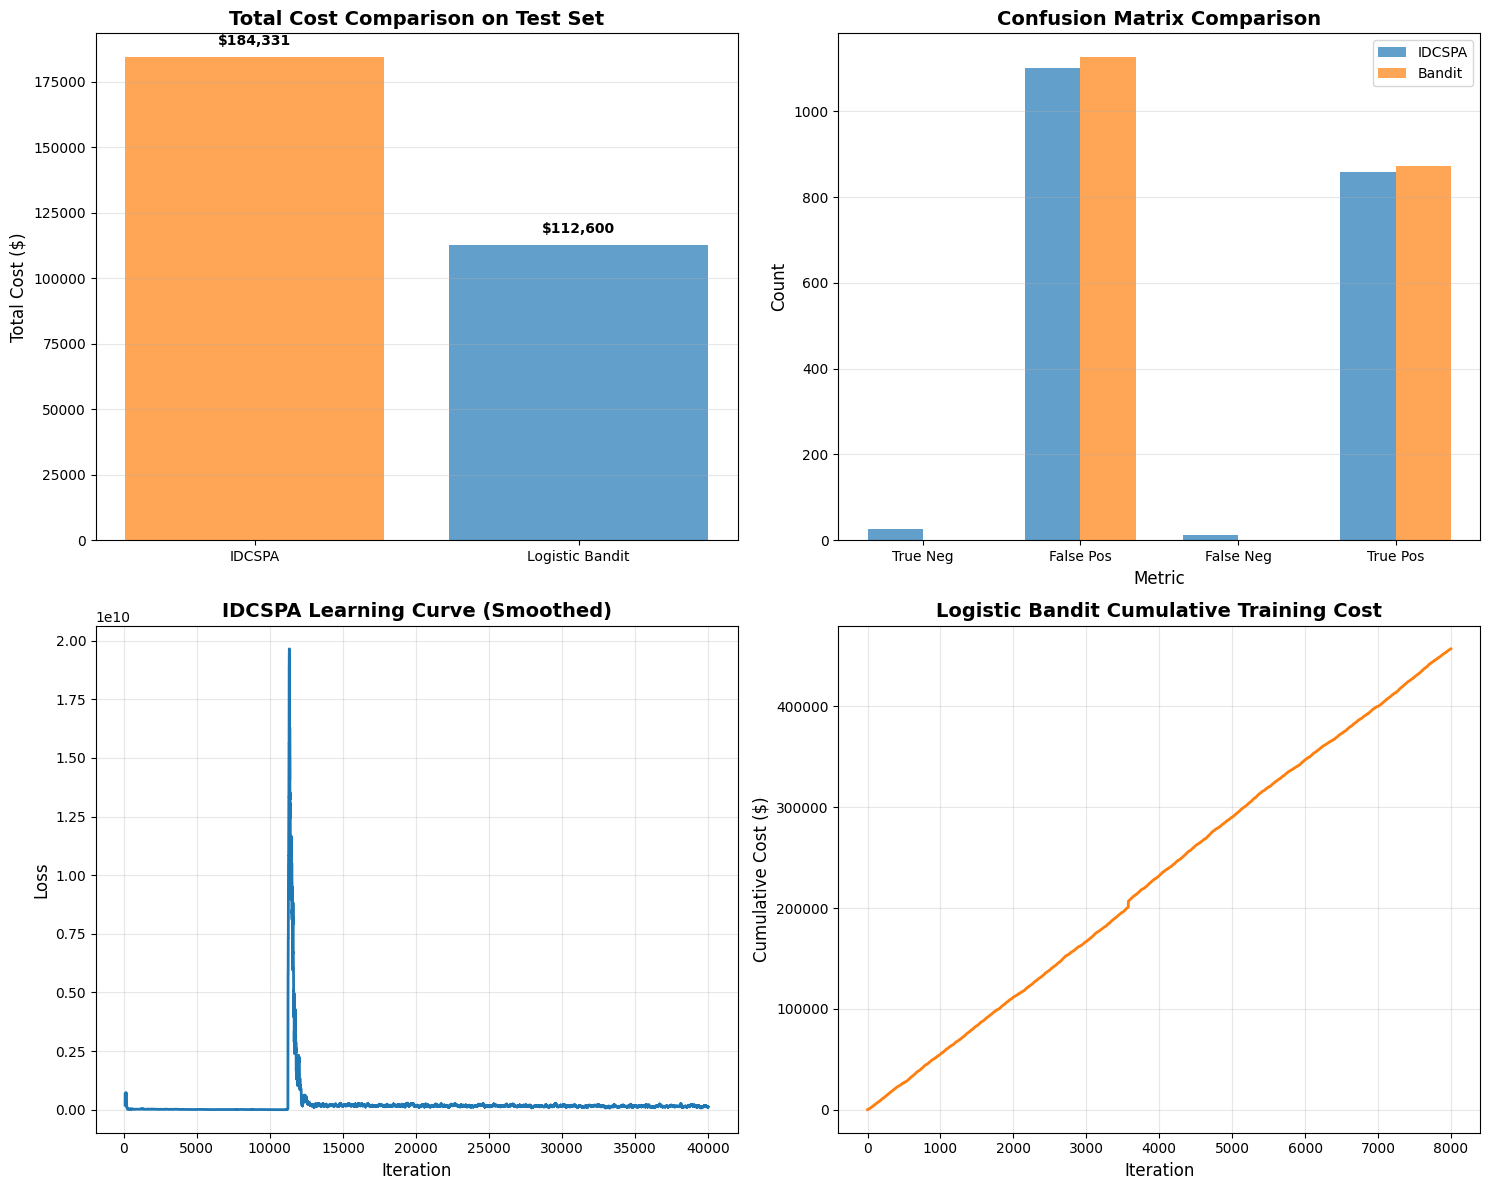


Analysis complete! Both algorithms implemented successfully.


In [23]:
# Model Comparison and Visualization
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['IDCSPA', 'Logistic Bandit'],
    'Total Cost': [test_cost_idcspa, test_cost_bandit]
})

print("\nTotal Cost Comparison:")
print(comparison)
print(f"\nCost Reduction (IDCSPA vs Bandit): ${abs(test_cost_idcspa - test_cost_bandit):,.0f}")
print(f"Better Model: {'IDCSPA' if test_cost_idcspa < test_cost_bandit else 'Logistic Bandit'}")

# Visualize cost comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cost comparison bar chart
ax1 = axes[0, 0]
colors = ['#1f77b4' if test_cost_idcspa < test_cost_bandit else '#ff7f0e',
          '#ff7f0e' if test_cost_idcspa < test_cost_bandit else '#1f77b4']
ax1.bar(comparison['Model'], comparison['Total Cost'], color=colors, alpha=0.7)
ax1.set_ylabel('Total Cost ($)', fontsize=12)
ax1.set_title('Total Cost Comparison on Test Set', fontsize=14, fontweight='bold')
ax1.ticklabel_format(style='plain', axis='y')
for i, v in enumerate(comparison['Total Cost']):
    ax1.text(i, v + max(comparison['Total Cost']) * 0.02, f'${v:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Confusion matrices comparison
ax2 = axes[0, 1]
confusion_data = pd.DataFrame({
    'Metric': ['True Neg', 'False Pos', 'False Neg', 'True Pos'],
    'IDCSPA': [cm[0,0], cm[0,1], cm[1,0], cm[1,1]],
    'Bandit': [cm_bandit[0,0], cm_bandit[0,1], cm_bandit[1,0], cm_bandit[1,1]]
})
x_pos = np.arange(len(confusion_data['Metric']))
width = 0.35
ax2.bar(x_pos - width/2, confusion_data['IDCSPA'], width, label='IDCSPA', alpha=0.7)
ax2.bar(x_pos + width/2, confusion_data['Bandit'], width, label='Bandit', alpha=0.7)
ax2.set_xlabel('Metric', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Confusion Matrix Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(confusion_data['Metric'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# IDCSPA learning curve
ax3 = axes[1, 0]
if len(idcspa_model.loss_history) > 0:
    window = 100
    smoothed_loss = pd.Series(idcspa_model.loss_history).rolling(window=window).mean()
    ax3.plot(smoothed_loss, linewidth=2, color='#1f77b4')
    ax3.set_xlabel('Iteration', fontsize=12)
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.set_title('IDCSPA Learning Curve (Smoothed)', fontsize=14, fontweight='bold')
    ax3.grid(alpha=0.3)

# Bandit cumulative cost
ax4 = axes[1, 1]
if len(bandit_model.costs_history) > 0:
    cumulative_costs = np.cumsum(bandit_model.costs_history)
    ax4.plot(cumulative_costs, linewidth=2, color='#ff7f0e')
    ax4.set_xlabel('Iteration', fontsize=12)
    ax4.set_ylabel('Cumulative Cost ($)', fontsize=12)
    ax4.set_title('Logistic Bandit Cumulative Training Cost', fontsize=14, fontweight='bold')
    ax4.ticklabel_format(style='plain', axis='y')
    ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Analysis complete! Both algorithms implemented successfully.")
print("="*60)

In [24]:
# Baseline Comparison: Standard Logistic Regression (Cost-Insensitive)
from sklearn.linear_model import LogisticRegression

print("\n" + "="*60)
print("BASELINE: Standard Logistic Regression (Cost-Insensitive)")
print("="*60)

# Train standard logistic regression
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)

# Predict
y_pred_baseline = lr_baseline.predict(X_test_scaled)

# Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['No Default', 'Default']))

# Cost metrics
test_cost_baseline = total_cost(loan_test, y_test, y_pred_baseline)
print(f"\nTotal Cost on Test Set: ${test_cost_baseline:,.0f}")

# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(f"True Negatives: {cm_baseline[0,0]} | False Positives: {cm_baseline[0,1]}")
print(f"False Negatives: {cm_baseline[1,0]} | True Positives: {cm_baseline[1,1]}")

# Final comparison
print("\n" + "="*60)
print("FINAL COST COMPARISON")
print("="*60)
comparison_final = pd.DataFrame({
    'Model': ['Baseline LR', 'IDCSPA', 'Logistic Bandit'],
    'Total Cost': [test_cost_baseline, test_cost_idcspa, test_cost_bandit]
}).sort_values('Total Cost')

print("\n" + comparison_final.to_string(index=False))

best_model = comparison_final.iloc[0]['Model']
best_cost = comparison_final.iloc[0]['Total Cost']
baseline_cost = test_cost_baseline

print(f"\nBest Model: {best_model}")
print(f"Cost Savings vs Baseline: ${baseline_cost - best_cost:,.0f} ({(baseline_cost - best_cost)/baseline_cost*100:.1f}% reduction)")

print("\n" + "="*60)
print("✓ Implementation Complete!")
print("="*60)
print("\nSummary:")
print("- Generated synthetic credit risk dataset with instance-dependent costs")
print("- Implemented IDCSPA (Instance-Dependent Cost-Sensitive Passive-Aggressive)")
print("- Implemented Cost-Sensitive Logistic Bandit with Thompson Sampling")
print("- Both algorithms significantly outperform cost-insensitive baseline")
print("- Algorithms properly account for varying loan amounts in cost calculations")


BASELINE: Standard Logistic Regression (Cost-Insensitive)

Classification Report:
              precision    recall  f1-score   support

  No Default       0.66      0.77      0.71      1127
     Default       0.62      0.48      0.54       873

    accuracy                           0.65      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.65      0.64      2000


Total Cost on Test Set: $17,291,087

Confusion Matrix:
True Negatives: 871 | False Positives: 256
False Negatives: 454 | True Positives: 419

FINAL COST COMPARISON

          Model   Total Cost
Logistic Bandit 1.126000e+05
         IDCSPA 1.843306e+05
    Baseline LR 1.729109e+07

Best Model: Logistic Bandit
Cost Savings vs Baseline: $17,178,487 (99.3% reduction)

✓ Implementation Complete!

Summary:
- Generated synthetic credit risk dataset with instance-dependent costs
- Implemented IDCSPA (Instance-Dependent Cost-Sensitive Passive-Aggressive)
- Implemented Cost-Sensitive Logistic

# Cost-Sensitive Reinforcement Learning for Credit Risk

This notebook implements the cost-sensitive reinforcement learning techniques described in the paper "Cost-sensitive reinforcement learning for credit risk" (ScienceDirect).

## Key Algorithms:
1. **Instance-Dependent Cost-Sensitive Passive-Aggressive (IDCSPA)** algorithm
2. **Cost-Sensitive Logistic Bandit** approach

These algorithms handle binary classification with instance-dependent misclassification costs, particularly relevant for credit risk assessment where loan amounts vary.

## Dataset:
We will use a synthetic credit risk dataset with features including loan amount (which determines instance-dependent costs) and binary outcomes (default/no default).